## Worked Example: Segmentation
As an example of a typical image processing problem, we will segment the following image of bacteria.

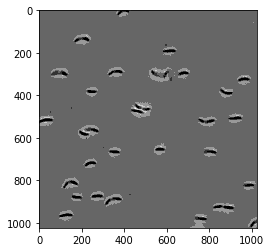

In [5]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

im = plt.imread('images/caulobacter.png')

plt.imshow(im)

original image shape: (1024, 1024, 4)
alpha channel intensity: 1.00 +- 0.00


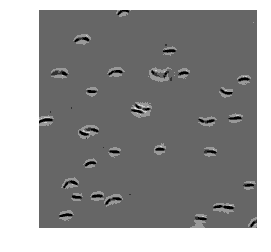

In [10]:
def my_imshow(im, title=None, **kwargs):
    if 'cmap' not in kwargs:
        kwargs['cmap'] = 'gray'
    plt.figure()
    plt.imshow(im, interpolation='none', **kwargs)
    if title:
        plt.title(title)
    plt.axis('off')

print ('original image shape: {}'.format(im.shape))
print ('alpha channel intensity: {0:.2f} +- {1:.2f}'.format(np.mean(im[:,:,-1]), np.std(im[:,:,-1]))
)
my_imshow(im)

First, convert from color (4 channel, actually) to grayscale.

grayscale image shape: (1024, 1024)


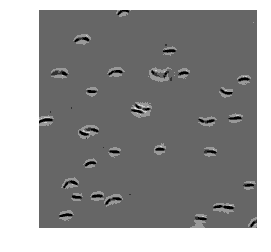

In [12]:
from skimage import color

# convert to gray 
gray_im = color.rgb2gray(im)
print ('grayscale image shape:', gray_im.shape)

my_imshow(gray_im)

Blur slightly to reduce noise. (This isn't strictly necessary in this case, since it's a fairly high-quality image.)

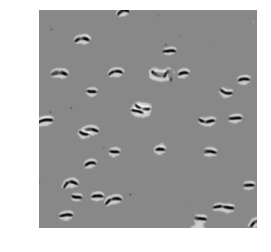

In [14]:
from skimage import filters

blurred_im = filters.gaussian(gray_im, sigma=3)
my_imshow(blurred_im)

After the image is suitable pre-processed, we can threshold it to convert it to a cell mask.

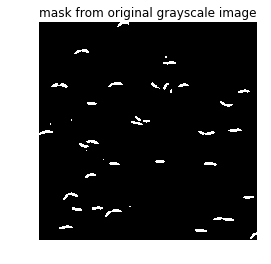

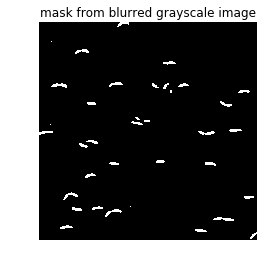

In [15]:
thresh = 0.3
mask = gray_im < thresh
blurred_mask = blurred_im < thresh

my_imshow(mask, title='mask from original grayscale image')
my_imshow(blurred_mask, title='mask from blurred grayscale image')

Binary images are manipulated with morphological operations. Morphological operations allow us to expand the white regions, shrink the white regions, fill in holes, and more. In this case, we simply want to remove the tiny dots.

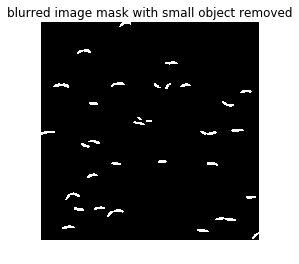

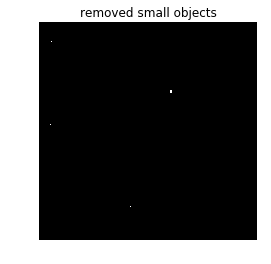

In [23]:
from skimage import morphology

blurred_mask_clean = morphology.remove_small_objects(blurred_mask, min_size=150)

my_imshow(blurred_mask_clean, title='blurred image mask with small object removed')
my_imshow(blurred_mask ^ blurred_mask_clean, 'removed small objects')

Some of the cells are touching, so they appear as one object, but we would like to identify them as separate objects. This is a very common problem in segmentation problems, noteably cell tracking. A common approach is to perform a distance transform, followed by a watershed segmentation.

The distance transform converts a binary mask (black-and-white image) into a floating point image (grayscale image) of the same size. Each pixel in the distance transform represents the distance of that pixel from the nearest black point in the mask. Thus, the brighest points in the distance transform are the points that are furthest from object boundaries. An example will help clarify.

distance transform: (1024, 1024) float64


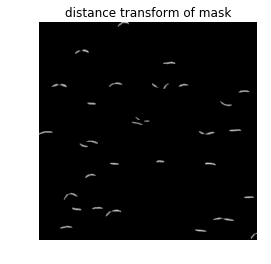

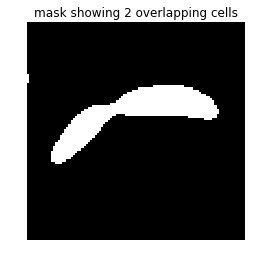

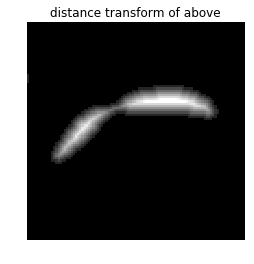

In [24]:
from scipy import ndimage as ndi

distance_im = ndi.distance_transform_edt(blurred_mask_clean)
print ('distance transform:', distance_im.shape, distance_im.dtype)

my_imshow(distance_im, title='distance transform of mask')
my_imshow(blurred_mask_clean[850:950, 300:400], title='mask showing 2 overlapping cells')
my_imshow(distance_im[850:950, 300:400], title='distance transform of above')

If we've done everything right, the peaks of the distance transform image represent the centers of each cell (including those that overlap). We label each separate peak with a unique integer with skimage.measure.label.

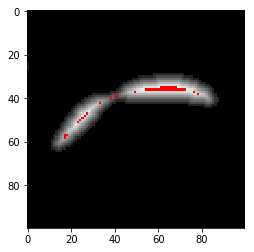

In [26]:
from skimage import feature, measure
from matplotlib.colors import ListedColormap

def imshow_overlay(im, mask, alpha=0.5, color='red', **kwargs):
    """Show semi-transparent red mask over an image"""
    mask = mask > 0
    mask = np.ma.masked_where(~mask, mask)        
    plt.imshow(im, **kwargs)
    plt.imshow(mask, alpha=alpha, cmap=ListedColormap([color]))


peaks_im = feature.peak_local_max(distance_im, indices=False)

plt.figure()
imshow_overlay(distance_im[850:950, 300:400], peaks_im[850:950, 300:400], alpha=1, cmap='gray')

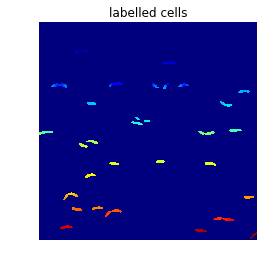

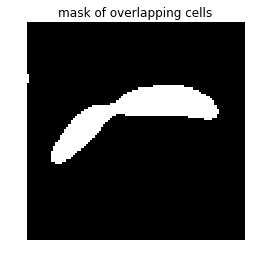

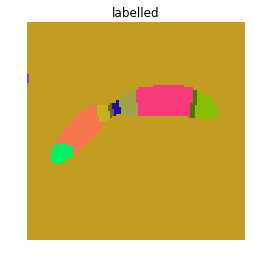

In [27]:
import matplotlib
random_colors = matplotlib.colors.ListedColormap (np.random.rand ( 256,3))


markers_im = measure.label(peaks_im)
labelled_cell_im = morphology.watershed(-distance_im, markers_im, mask=blurred_mask_clean)

my_imshow(labelled_cell_im, 'labelled cells', cmap='jet')
my_imshow(blurred_mask_clean[850:950, 300:400], 'mask of overlapping cells')
my_imshow(labelled_cell_im[850:950, 300:400], 'labelled', cmap=random_colors)